In [1]:
import gc
import math
import itertools

import numpy as np
import pandas as pd
from pprint import pprint as pp

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

import scipy.stats as st
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, DBSCAN, OPTICS

import infoStructure as ins
import helpers as hp
import clustering as cl
import display as dp
import importlib #importlib.reload(foo)

> Point to the directories (output for the processed mat files and where the mat files reside

In [2]:
INPUTDir = '/media/valeporti/ADATA SH14/stg/Brest/' # the directory where the all the patients are (RS1000, RS10001...)
OUTPUTDir = '/media/valeporti/ADATA SH14/stg/'
# also, the variables to get from .mat files used all along the study
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue', 'darkorange', 'gold', 
                              'tomato', 'crimson', 'darkslategray', 'springgreen', 'chocolate'])
titles = ['vectorRRKLD', 'vectorFAmpKLD', 'vectorUFAmpKLD', 'vectorCorrKLD'] 
feat_dict = None
df_ALL = None
show_normalized_values = False

> Grab all the patients directory that you need, and the specific features from the 34

<span style="color:red">Just needed to extract information. If needed, remove the tripple quotes</span>
```python
""" commented code """
```

> /!\ ATENTION: in the "addAllPatientsInfoV4" script, the most suitable variable for scalable data is to_hdf = True, because it won't saturate RAM, even though, it's bigger than feather in ROM and takes more time on loading. 

> Because of this, the recommended way to do this is to extract [100] patients (as quantities) and since they are taken randomly from the source, this would help, afterwards around 75% from this info should be extracted to do the further calculations

In [3]:
"""# files to save (of 5, and 10 and 50 ... patients inside)
quantities = [5, 10, 20, 50, 100] #[5, 10, 50, 100, 200] # max num of patients = 524
## randomly
ins.addAllPatientsInfoV4(INPUTDir, titles, quantities, OUTPUTDir, to_hdf=True)
"""

'# files to save (of 5, and 10 and 50 ... patients inside)\nquantities = [5, 10, 20, 50, 100] #[5, 10, 50, 100, 200] # max num of patients = 524\n## randomly\nins.addAllPatientsInfoV4(INPUTDir, titles, quantities, OUTPUTDir, to_hdf=True)\n'

** Grab the information previously treated and saved as a feather file **

In [4]:
name_of_file = '100_f32.h5' #'550_32.feather'

# if the information has been grabed from previous cell (from patients input files)
#df_ALL = hp.convertDictInDF(feat_dict)
df_ALL = hp.readFileToPandas(OUTPUTDir + name_of_file)

reading h5


In [5]:
df_ALL.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25243388 entries, 0 to 25243387
Data columns (total 6 columns):
vectorRRKLD       float32
voie_num          uint8
vectorFAmpKLD     float32
vectorUFAmpKLD    float32
vectorCorrKLD     float32
paths             object
dtypes: float32(4), object(1), uint8(1)
memory usage: 794.4+ MB


In [6]:
df_ALL.head()

,vectorRRKLD,voie_num,vectorFAmpKLD,vectorUFAmpKLD,vectorCorrKLD,paths
0,14.223434,0,6.777984,7.056729,0.278745,RS10143/RS10143_150408_102446.mat
1,14.086390,0,5.879048,6.041784,0.162735,RS10143/RS10143_150408_102446.mat
2,13.953464,0,5.964413,6.127149,0.162736,RS10143/RS10143_150408_102446.mat
3,13.829085,0,6.013064,6.120740,0.107676,RS10143/RS10143_150408_102446.mat
4,13.731248,0,6.047493,6.155169,0.107676,RS10143/RS10143_150408_102446.mat


** According to the quantity of the memory available, grab randomly the rows for the study of the data **
> 0.22 (22%) for a 16Go RAM memory avaliable computer, for one model

> 0.16 for a 16Go RAM memory available computer, for running several models (like GMM but several times to get the best BIC score)

In [7]:
df_DIV, indexes, ignored_df, ignored_indexes = hp.getRandomRows(df_ALL, 0.5)
df_DIV, df_info = hp.cleanDF(df_DIV, ['paths', 'voie_num']) # divide DF between pure info and data
ignored_df, ignored_df_info = hp.cleanDF(ignored_df, ['paths', 'voie_num'])

### Preprocessing

In [8]:
df_DIV = cl.cleanData(df_DIV, 'mean') # impute non available data in the columns using a strategy (mean, median, most_frequent)
ignored_df = cl.cleanData(ignored_df, 'mean')

> Dependign if PCA wants to be applied, run one or the other, in this step, removing outliers and normalization takes place

> Besides, in order to do a hard removal for the difficult "vectorUFAmpKLD" feature removal, choose v3=True for the runOutNormV2, else, if just wanted it to be handled with the meanshift appraoch, use v3=False

In [9]:
df_nout, Xnorm, std, indexes2 = cl.runOutNormV2(df_DIV, indexes, threshold=20, threshold_hard=0.01, v3=True)
norm_arg = {'X_is_normalized': False, 'std': None} if show_normalized_values else { 'X_is_normalized':True, 'std': std }
## for PCA run this one
#df_nout, Xnorm, Xpca, dfPca, titPca, pca, std, indexes2 = cl.runOutNormPCAV2(df_DIV, indexes, threshold=20, threshold_hard=0.01, cols_hard=[0,2])

bandwidth: 2613260139491174.5
number of estimated clusters : 2
shapes: (12621694,), (12621694, 4)
to_maintain_indexes  [ True  True  True ...  True  True  True]
after hard removal (vectorUFAmpKLD && vectorRRKLD) shape : (12220901, 4) && 96.82
after soft removal (vectorCorrKLD && vectorFAmpKLD) shape : (12621694, 4) && 100.0


> declare which matrix of data should be used for the models according to the previous choice

In [10]:
X = Xnorm # Xnorm or Xpca

> print data as obtained from preprocessing, 
 ```python
if Xpca, the "titPca" variable should be passed,
else titles of columns should be passed (['vectorRRKLD', 'vectorFAmpKLD', 'vectorUFAmpKLD', 'vectorCorrKLD'])
```

In [11]:
del df_nout; gc.collect()
# del dfPca; gc.collect()

0

### Model

```python 
if used v3=False for the preprorcessing step (runOutNormV2 function), components should be around 8 and 10
else components are around 6 and 8
```

In [12]:
gmm = GaussianMixture(n_components=7, covariance_type='full', random_state=0).fit(X)
#gmm10 = GaussianMixture(n_components=10, covariance_type='full').fit(X)

In [13]:
gmm_to_print = gmm

predicted = gmm_to_print.predict(X)
representativeness = hp.getRepresentativeness(gmm_to_print, X, predicted)
repre_dict = hp.getObjOfRepresentativeness(representativeness)
pp(repre_dict)

totals: {'>50': 1, '>30': 0, '>15': 0, '>05': 2, '<05': 4}
{0: {'group': 0, 'qty': 1646655, 'representativeness': 0.13474088367134304},
 1: {'group': 1, 'qty': 9032112, 'representativeness': 0.7390708753798104},
 2: {'group': 2, 'qty': 300, 'representativeness': 2.4548108195950527e-05},
 3: {'group': 3, 'qty': 3814, 'representativeness': 0.00031208828219785105},
 4: {'group': 4, 'qty': 523002, 'representativeness': 0.042795698942328396},
 5: {'group': 5, 'qty': 911499, 'representativeness': 0.07458525357500237},
 6: {'group': 6, 'qty': 103519, 'representativeness': 0.008470652041122009}}


> **<span style="color:red">/!\ important /!\ get the original values (undo normalization to see real data)</span>**

In [15]:
X_orig = cl.getValuesBeforeNormalization(X, std)

**<span style="color:red">Extract the desired data from a cluster, complemented with its information</span>**

In [16]:
num_of_samples = 5
cluster = 0
hp.getFromClusterInfo(X, predicted, num_of_samples, indexes2, cluster, df_info, titles, **norm_arg)

,paths,voie_num,vectorRRKLD,vectorFAmpKLD,vectorUFAmpKLD,vectorCorrKLD
1784484,RS10280/RS10280_160427_235041.mat,1,9.959721,28.387461,30.988832,2.601371
15994106,RS10221/RS10221_140523_091742.mat,1,11.680126,5.697615,25.872320,20.174706
4088749,RS10179/RS10179_161219_104513.mat,2,17.432972,6.911502,30.435051,23.523548
23163722,RS10286/RS10286_161116_113748.mat,0,18.854395,7.961863,46.472145,38.510281
6512116,RS10404/RS10404_181228_143719.mat,0,16.284439,67.519127,72.258850,4.739719


**<span style="color:red">Get the N samples of points "around" each of the calculated centers (mean of each mixture component</span>**

In [17]:
num_of_samples = 5
for c, cluster_center in enumerate(gmm_to_print.means_):
  print(f'cluster group ({c}), representativity: { round(repre_dict[c]["representativeness"] * 100, 2) }%, center_vector_values: {cl.getValuesBeforeNormalization(cluster_center, std) if not show_normalized_values else cluster_center}')
  display(hp.getFromNearestInfo(cluster_center, X, num_of_samples, indexes2, df_info, titles, **norm_arg))

cluster group (0), representativity: 13.47%, center_vector_values: [3.14500778e+04 2.03341131e+01 3.74814000e+01 1.71483114e+01]


,paths,voie_num,vectorRRKLD,vectorFAmpKLD,vectorUFAmpKLD,vectorCorrKLD
13079175,RS10241/RS10241_150102_115512.mat,2,15.339546,20.312931,37.472588,17.159655
11521881,RS10427/RS10427_190129_150055.mat,2,15.376176,20.148111,37.286812,17.138699
18867611,RS10379/RS10379_190206_142935.mat,1,15.188915,20.587610,37.741825,17.154215
13124237,RS10241/RS10241_150102_115512.mat,2,12.494858,20.346216,37.466110,17.119896
2382141,RS10280/RS10280_160428_115041.mat,0,10.323516,19.997055,37.160839,17.163788


cluster group (1), representativity: 73.91%, center_vector_values: [11.71984802  5.66171261 12.77982355  7.11903222]


,paths,voie_num,vectorRRKLD,vectorFAmpKLD,vectorUFAmpKLD,vectorCorrKLD
13641565,RS10260/RS10260_141222_214321.mat,0,10.618273,5.661415,12.780935,7.119519
23518558,RS10039/RS10039_170303_101244.mat,2,9.209772,5.657025,12.775658,7.118632
25174809,RS10515/RS10515_181119_140932.mat,1,7.256969,5.656801,12.776234,7.119432
20051420,RS10123/RS10123_170109_094743.mat,2,9.240499,5.662850,12.781162,7.118312
13815330,RS10260/RS10260_141222_214321.mat,2,10.869842,5.662268,12.782111,7.119843


cluster group (2), representativity: 0.0%, center_vector_values: [3.78609547e+12 2.58998818e+01 3.15824954e+01 5.69413228e+00]


,paths,voie_num,vectorRRKLD,vectorFAmpKLD,vectorUFAmpKLD,vectorCorrKLD
20093031,RS10424/RS10424_190319_123154.mat,0,737098176.0,11.318616,16.863636,5.545021
20093030,RS10424/RS10424_190319_123154.mat,0,737098176.0,11.318616,16.863636,5.545021
1807805,RS10280/RS10280_160427_235041.mat,2,737098176.0,11.259432,16.822361,5.562930
20077557,RS10424/RS10424_190319_123154.mat,0,737098176.0,10.909773,16.112349,5.202576
20077558,RS10424/RS10424_190319_123154.mat,0,737098176.0,10.909773,16.112349,5.202576


cluster group (3), representativity: 0.03%, center_vector_values: [1.93325312e+01 8.14439206e+02 3.86618425e+04 1.17102566e+01]


,paths,voie_num,vectorRRKLD,vectorFAmpKLD,vectorUFAmpKLD,vectorCorrKLD
21540062,RS10229/RS10229_150105_071543.mat,2,19.334988,814.650635,38642.699219,11.710257
21541930,RS10229/RS10229_150105_071543.mat,2,19.334988,814.650635,38642.699219,11.710257
21540393,RS10229/RS10229_150105_071543.mat,2,19.334988,814.650635,38642.699219,11.710257
21542669,RS10229/RS10229_150105_071543.mat,2,19.334988,814.650635,38642.699219,11.710257
21538359,RS10229/RS10229_150105_071543.mat,2,19.334988,814.650635,38642.699219,11.710257


cluster group (4), representativity: 4.28%, center_vector_values: [ 18.96723379 300.29486218 303.75428919  11.05298608]


,paths,voie_num,vectorRRKLD,vectorFAmpKLD,vectorUFAmpKLD,vectorCorrKLD
16503989,RS10060/RS10060_170222_100557.mat,0,10.512458,300.053131,311.144196,11.091055
16494242,RS10060/RS10060_170222_100557.mat,0,11.313200,301.354248,312.337799,10.983565
16503999,RS10060/RS10060_170222_100557.mat,0,10.906745,301.450012,312.562988,11.112965
20534308,RS10352/RS10352_170717_145923.mat,1,15.449165,299.014343,309.964050,10.949696
903073,RS10336/RS10336_171030_093437.mat,0,17.753452,302.112122,313.226715,11.114639


cluster group (5), representativity: 7.46%, center_vector_values: [10.19244082  5.55666036 12.38793428  6.98659803]


,paths,voie_num,vectorRRKLD,vectorFAmpKLD,vectorUFAmpKLD,vectorCorrKLD
5580117,RS10523/RS10523_190312_030900.mat,2,13.688047,5.552081,12.538630,6.986549
16011453,RS10221/RS10221_140523_091742.mat,1,13.854761,5.556481,12.543361,6.986879
20051404,RS10123/RS10123_170109_094743.mat,2,9.174804,5.546038,12.532536,6.986498
2841576,RS10051/RS10051_170327_152801.mat,1,9.942018,5.548240,12.535322,6.987082
16255731,RS10221/RS10221_140523_131742.mat,1,13.768414,5.558684,12.544621,6.985936


cluster group (6), representativity: 0.85%, center_vector_values: [ 13.3770472  252.61220143 590.3044552   11.1751862 ]


,paths,voie_num,vectorRRKLD,vectorFAmpKLD,vectorUFAmpKLD,vectorCorrKLD
20330384,RS10352/RS10352_170717_105923.mat,0,17.152836,261.744476,495.989136,11.827065
5940263,RS10389/RS10389_190118_023535.mat,2,11.452956,248.004272,515.562378,10.028565
20325012,RS10352/RS10352_170717_105923.mat,0,16.965946,269.412628,521.015137,11.277987
20325011,RS10352/RS10352_170717_105923.mat,0,16.939943,269.863892,523.102173,11.141509
20330386,RS10352/RS10352_170717_105923.mat,0,16.551546,260.521118,471.777435,10.688239


**<span style="color:red">Get N Values from not studied points and assign to cluster</span>**

In [18]:
cl.getNValuesFromDFAndAssignCluster(ignored_df, gmm_to_print, std, n=18)

,vectorRRKLD,vectorFAmpKLD,vectorUFAmpKLD,vectorCorrKLD,cluster
5346593,13.502584,3.504821,8.255831,4.751010,1
8264742,15.280384,4.354023,10.879845,6.525822,1
8661831,9.556164,3.725475,10.194955,6.469480,1
11810980,8.641178,2.313851,9.517303,7.203452,1
7338117,15.143909,6.179652,38.388741,32.209087,0
11696947,7.352000,3.031990,6.019981,2.987991,1
10444375,9.372128,4.626437,10.043409,5.416972,1
1024050,9.753927,8.488955,18.827002,3.087644,5
4715165,14.435453,4.308999,19.427414,15.118414,1
12235087,6.657793,4.349043,8.900700,4.551656,1


> ** TO PRINT**

```python
# for 2d prinring of all clusters together (6 images), use: 
dp.printPCAGMM(gmm_to_print, X, titles, color_iter)
# for 2d printing of one cluster, use next: 
# ( gmm, gmm.predict(X), cluster #, column_1_to_display, column_2_to_display, color_of_cluster, titles )
fig, ax = plt.subplots(1, 1)
dp.plotOneGMMCluster(ax, X, predicted, 0, 0, 1, 'turquoise', titles)
# for 3d printing of onw cluster, use next: 
# ( 3dfig, gmm, gmm.predict(X), cluster #, column_1_to_display, column_2_to_display, column_3_to_display, color_of_cluster, titles)
ax = plt.axes(projection='3d') # just once!!
dp.plotOneGMMCluster3D(ax, X, predicted, 2, 0, 1, 2, 'turquoise', titles)
# to print all 6 possible combinations 
dp.plotAll2DGMMs(X, predicted, 1, 'turquoise', titles)
```

> <span style="color:red">put one plot by cell, if not, dynamic display wont appear for each plot</span>

** For each cluster, and for different features, the next cell chould be modified taking into accunt the variables mentioned above ** 

*Since just one cluster colored by 2 cells considering 4 dimensions, 2 plots must be donne to show each cluster according the 4 dimensions in a 3d plot*

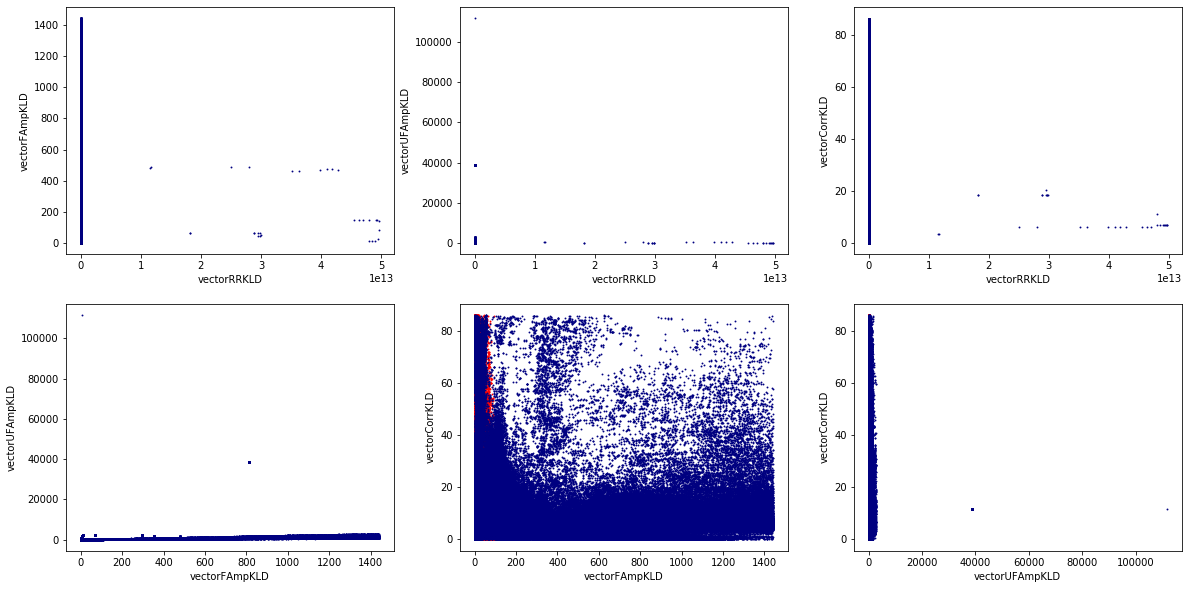

In [21]:
%matplotlib inline 
X_to_print = X if show_normalized_values else X_orig
dp.plotAll2DGMMs(X_to_print, predicted, 0, 'red', titles)

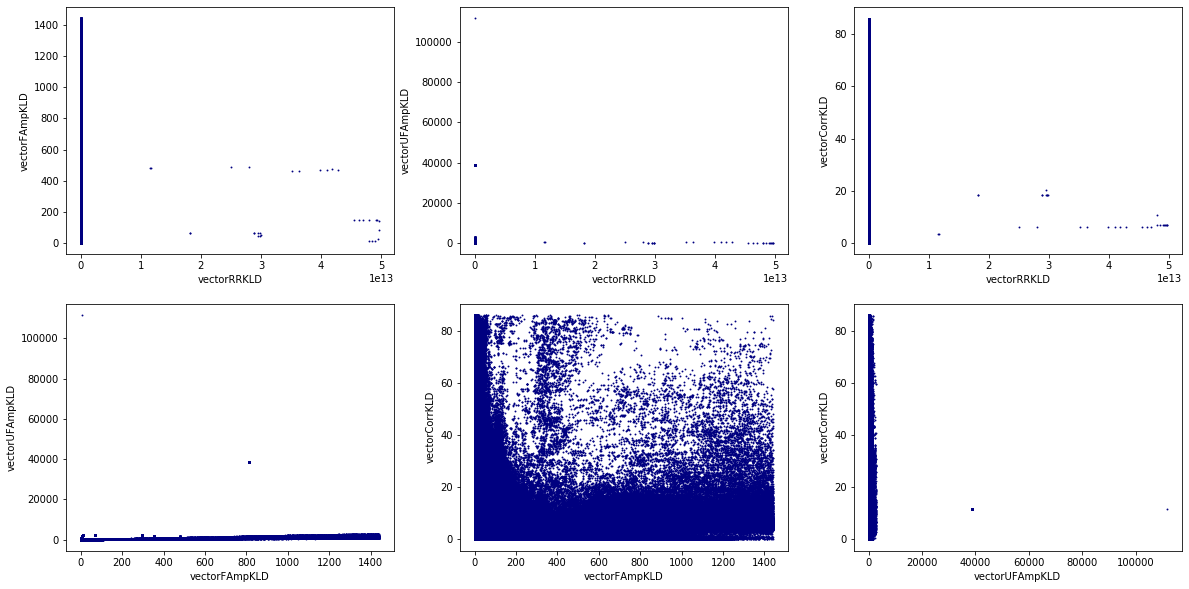

In [22]:
%matplotlib inline 
dp.plotAll2DGMMs(X_to_print, predicted, 1, 'red', titles)

----------------------------------------------------
<span style="color:red">Ignore Displayed plots, they have nothing to do with previus calculations meaning that they have been produced with other data, they haven't been run recently</span>

----------------------------------------------------

### 3D MANIPULATION

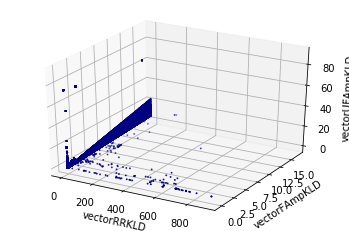

6091

In [20]:
# to show a dinamic view "%matplotlib notebook" , if not desired, use "%matplotlib inline"
%matplotlib inline 
ax = plt.axes(projection='3d')
dp.plotOneGMMCluster3D(ax, X, predicted, 0, 0, 1, 2, 'turquoise', titles)
plt.show(); plt.clf(); plt.close(); gc.collect()

<IPython.core.display.Javascript object>


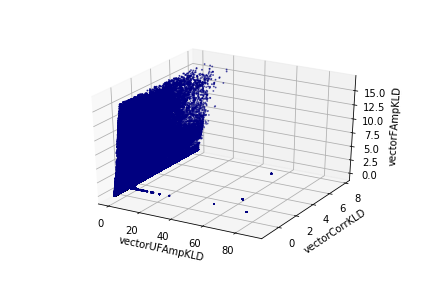

In [19]:
ax = plt.axes(projection='3d')
dp.plotOneGMMCluster3D(ax, X, predicted, 0, 2, 3, 1, 'red', titles)
plt.show(); #plt.clf(); plt.close(); gc.collect()

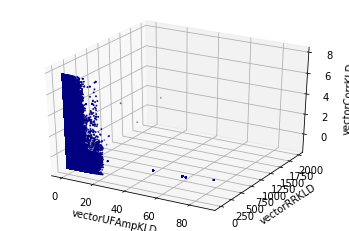

3061

In [35]:
ax = plt.axes(projection='3d')
dp.plotOneGMMCluster3D(ax, X, predicted, 1, 2, 0, 3, 'red', titles)
plt.show(); plt.clf(); plt.close(); gc.collect()

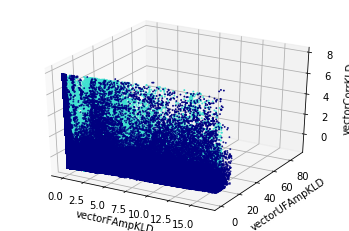

3293

In [24]:
ax = plt.axes(projection='3d')
dp.plotOneGMMCluster3D(ax, X, predicted, 2, 1, 2, 3, 'turquoise', titles)
plt.show(); plt.clf(); plt.close(); gc.collect()

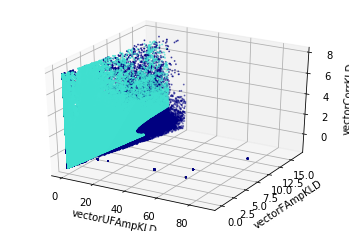

5621

In [29]:
ax = plt.axes(projection='3d')
dp.plotOneGMMCluster3D(ax, X, predicted, 2, 2, 1, 3, 'turquoise', titles)
plt.show(); plt.clf(); plt.close(); gc.collect()

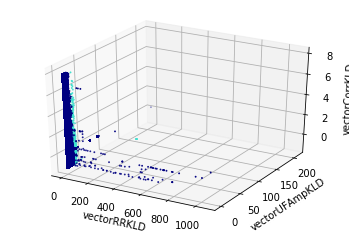

In [15]:
# to show a dinamic view "%matplotlib notebook" , if not desired, use "%matplotlib inline"
%matplotlib inline 
ax = plt.axes(projection='3d')
dp.plotOneGMMCluster3D(ax, X, predicted, 3, 0, 2, 3, 'turquoise', titles)
plt.show(); plt.clf(); plt.close(); gc.collect()

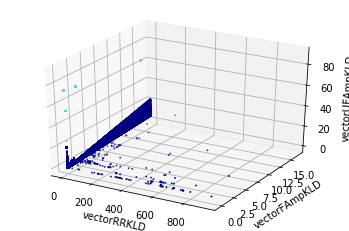

In [17]:
ax = plt.axes(projection='3d')
dp.plotOneGMMCluster3D(ax, X, predicted, 4, 0, 1, 2, 'turquoise', titles)
plt.show(); plt.clf(); plt.close(); gc.collect()

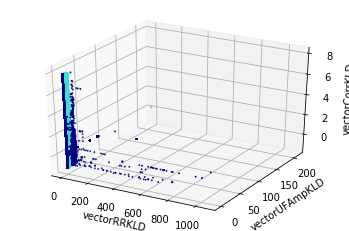

In [16]:
ax = plt.axes(projection='3d')
dp.plotOneGMMCluster3D(ax, X, predicted, 5, 0, 2, 3, 'turquoise', titles)
plt.show(); plt.clf(); plt.close(); gc.collect()

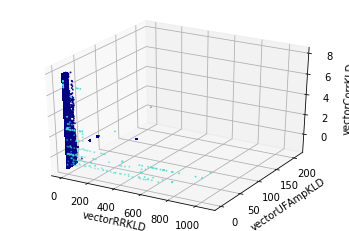

In [17]:
ax = plt.axes(projection='3d')
dp.plotOneGMMCluster3D(ax, X, predicted, 6, 0, 2, 3, 'turquoise', titles)
plt.show(); plt.clf(); plt.close(); gc.collect()

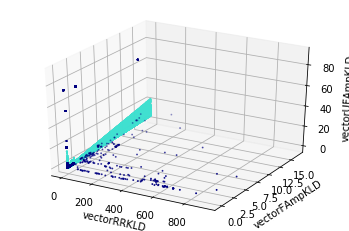

In [17]:
ax = plt.axes(projection='3d')
dp.plotOneGMMCluster3D(ax, X, predicted, 1, 0, 1, 2, 'turquoise', titles)
plt.show(); plt.clf(); plt.close(); gc.collect()

### Understand de BIC (Bayesian Information Criterion) Optional
> If runned, take into account the percentage of data from the total, for a 16Go computer it will only support 15% og the 120 million rows with 4 features in float32

In [ ]:
"""
n_components_range = range(5, 12)
best_gmm, bic, cv_types = cl.getBestGMMUsingBIC(X, n_components_range, ['full'], 0.1)
bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue', 'darkorange', 'gold', 'tomato', 'crimson', 'darkslategray', 'springgreen', 'chocolate'])
dp.plotBICScores(bic, cv_types, color_iter, n_components_range)
"""